In [1]:
# !pip install basemap

In [2]:
import pandas as pd # data-frame manipulation
from tqdm.auto import tqdm # progress bar
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import numpy as np # linear algebra
from mpl_toolkits.basemap import Basemap # map plotting
import requests # fetching data from the internet
from scipy import stats # statistical tests

# set the plot style
sns.set(context='paper', style='ticks',
        font_scale=1, palette='colorblind')

/Users/alexeykoshevoy/.pyenv/versions/cpes_3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Question

This TD will answer the following question:

*Does the average temperature affect the colexification of SNOW and ICE in the languages of the world?*

Yesterday, we looked at [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0151138), where the authors tested whether languages spoken in the colder climates are more likely to colexify the senses ICE and SNOW than the languages spoken in the warmer climates. However, they have only looked at 166 languages, while we have the possibility to test this hypothesis on a much larger set of languages from the [Lexibank](https://lexibank.clld.org/) database. The goal of today session would be to reproduce their results on a much larger sample of languages

## Data

### 1. Extracting data from Lexibank

First, we will need to extract data from Lexibank. It has been conveniently gathered for you by the creators of this database, so you can look at it below:

In [3]:
all_lexibank = pd.read_csv('https://github.com/alexeykosh/intro-to-ling/raw/refs/heads/main/S8/lexibank_clipped.csv',
                           low_memory=False, index_col=0)
all_lexibank.head(5)

,Language_ID,Form,Latitude,Longitude,Glottocode,Concepticon_Gloss,Family
0,aaleykusunda-KusundaK,ɐ̃ː.ʤi,28.000000,82.260000,kusu1250,ABOVE,NaN
1,abrahammonpa-MonpaKalaktang,thuŋga,27.104162,92.113017,kala1376,ABOVE,Sino-Tibetan
2,abrahammonpa-MonpaDirang,thuŋga,27.349590,92.279140,tsha1245,ABOVE,Sino-Tibetan
3,abrahammonpa-MonpaChangprong,jur,27.578928,91.876393,dakp1242,ABOVE,Sino-Tibetan
4,abrahammonpa-SartangDarbuB,khuŋlo,27.329171,92.358727,sart1249,ABOVE,Sino-Tibetan


Let's try to make sense of different columns first:

In [4]:
all_lexibank.columns

Index(['Language_ID', 'Form', 'Latitude', 'Longitude', 'Glottocode',
       'Concepticon_Gloss', 'Family'],
      dtype='object')

What columns do you think we will need to consider for testing the hypothesis in question? Let's also look at how many rows it has:

In [5]:
all_lexibank.shape

(709638, 7)

How many unique languages are there?

In [6]:
all_lexibank['Glottocode'].nunique()

2029

How many linguistc families?

In [7]:
all_lexibank['Family'].nunique()

192

In [8]:
all_lexibank.query('Glottocode == "stan1290"')

,Language_ID,Form,Latitude,Longitude,Glottocode,Concepticon_Gloss,Family
1303,northeuralex-fra,tu,48.0,2.0,stan1290,ALL,Indo-European
2640,northeuralex-fra,fuʁˈmi,48.0,2.0,stan1290,ANT,Indo-European
3809,northeuralex-fra,moˈvɛ,48.0,2.0,stan1290,BAD,Indo-European
6016,northeuralex-fra,viˈvɑ̃,48.0,2.0,stan1290,BE ALIVE,Indo-European
6017,northeuralex-fra,ˈviːvʁə,48.0,2.0,stan1290,BE ALIVE,Indo-European
...,...,...,...,...,...,...,...
687284,northeuralex-fra,tʁaˈdɥiːʁ,48.0,2.0,stan1290,TRANSLATE,Indo-European
687395,northeuralex-fra,ʁəmaʁˈke,48.0,2.0,stan1290,NOTICE (SOMETHING),Indo-European
687396,northeuralex-fra,apɛʁsəˈvwaːʁ,48.0,2.0,stan1290,NOTICE (SOMETHING),Indo-European
687516,northeuralex-fra,ʁəkɔˈnɛːtʁə,48.0,2.0,stan1290,RECOGNIZE (SOMEBODY),Indo-European


In [9]:
all_lexibank[all_lexibank['Family'].isna()]

,Language_ID,Form,Latitude,Longitude,Glottocode,Concepticon_Gloss,Family
0,aaleykusunda-KusundaK,ɐ̃ː.ʤi,28.000000,82.260000,kusu1250,ABOVE,NaN
8,abrahammonpa-HrusoAkaJamiri,ʔodɹu,27.184929,92.599114,hrus1242,ABOVE,NaN
402,johanssonsoundsymbolic-Abun,nim,-0.570730,132.416000,abun1252,ABOVE,NaN
407,johanssonsoundsymbolic-Alsea,qauʔx,44.408000,-123.940000,alse1251,ABOVE,NaN
411,johanssonsoundsymbolic-Atakapa,itse,30.912100,-93.082700,atak1252,ABOVE,NaN
...,...,...,...,...,...,...,...
708392,transnewguineaorg-pyu,ᵽuǥiʔ,-4.450030,141.018000,pyuu1245,EARTH (WET SUBSTANCE),NaN
709303,transnewguineaorg-pyu,budiaʔ,-4.450030,141.018000,pyuu1245,FISHING SPEAR,NaN
709561,transnewguineaorg-keuw,préem-ô,-3.193280,136.140000,kehu1238,JOURNEY,NaN
709562,transnewguineaorg-keuw,páudn-yó_məә̀kəә̀-yô,-3.193280,136.140000,kehu1238,TOENAIL,NaN


Ok, now let's focus on our hypothesis. We are interested in two senses from lexibank, namely SNOW and ICE. Let's store them in a list as strings:

In [10]:
terms_for_snow = [
    "ICE", "SNOW"
]

We will not need all the columns, but we will need the following four:

In [11]:
all_lexibank = all_lexibank[['Form', 'Concepticon_Gloss', 'Glottocode', 'Family']]

Get the subset of the forms from Lexibank that contain the words for SNOW and ICE:

In [12]:
subset_si = all_lexibank.query(f'Concepticon_Gloss in {terms_for_snow}')

Great, now we have the subset of words

In [13]:
subset_si.head(5)

,Form,Concepticon_Gloss,Glottocode,Family
119217,jaːq,ICE,kusu1250,NaN
119218,kak,ICE,khoi1252,Sino-Tibetan
119219,kʰɛt,ICE,chug1252,Sino-Tibetan
119220,kʰɛk,ICE,lish1235,Sino-Tibetan
119221,hau,ICE,hawa1245,Austronesian


Let's look at a language that has many forms:

In [14]:
subset_si.query('Glottocode == "russ1263"')

,Form,Concepticon_Gloss,Glottocode,Family
119295,lot,ICE,russ1263,Indo-European
207482,snʲeˑk,SNOW,russ1263,Indo-European


And just one form for both:

In [15]:
subset_si.query('Glottocode == "chug1252"')

,Form,Concepticon_Gloss,Glottocode,Family
119219,kʰɛt,ICE,chug1252,Sino-Tibetan
207379,nam+ʑu,SNOW,chug1252,Sino-Tibetan


Now you need to extract the number of unique terms (unique Form) for every language in the database. Note that we only need to consider languages that have at least two Concepticon_Gloss entries. Write your code below to fill the list `lang_colex` with the following entries `[glottocode, number_of_unique_forms]`

In [16]:
lang_colex = []

for glottocode in subset_si.Glottocode.unique():
    data_lg = subset_si.query(f'Glottocode == "{glottocode}"')

    if data_lg.Concepticon_Gloss.nunique() >= 2:
        lang_colex.append([glottocode, len(data_lg.Form.unique())])


Let's look at the results, you should get the following result if everything is correct:

```
[['kusu1250', 1],
 ['khoi1252', 2],
 ['chug1252', 2],
 ['lish1235', 2],
 ['hawa1245', 1]]
```

In [17]:
lang_colex[:5]

[['kusu1250', 1],
 ['khoi1252', 2],
 ['chug1252', 2],
 ['lish1235', 2],
 ['hawa1245', 1]]

In [18]:
len(lang_colex)

269

Now let's convert it into a dataframe:

In [19]:
df_colex = pd.DataFrame(lang_colex)
df_colex.columns = ['glottocode', 'Number_of_terms']

Let's look at the distibution of the number of terms in the df_colex dataframe:

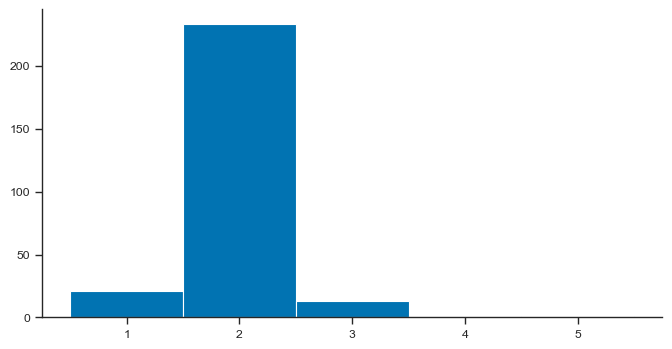

In [20]:
plt.figure(figsize=(8, 4))
plt.hist(df_colex['Number_of_terms'],
         bins=range(1, 7),
         align='left')
sns.despine()
plt.show()

Let's look at the languages that have more than two terms. Is there something interesting that you can notice?

In [21]:
df_colex.query('Number_of_terms > 2')

,glottocode,Number_of_terms
33,embe1260,3
37,embe1261,3
38,embe1262,4
39,epen1239,3
57,stan1289,3
78,drun1238,3
92,nucl1302,3
109,hmon1333,3
141,sout2674,3
158,nene1249,3


Normally, the language with the highest number of terms should be Romanian, so let's look a the terms in Romanian -- does the data look good?

In [22]:
subset_si.query('Glottocode == "roma1327"')

,Form,Concepticon_Gloss,Glottocode,Family
119431,gheaţă,ICE,roma1327,Indo-European
207642,zăpadă,SNOW,roma1327,Indo-European
207643,omăt,SNOW,roma1327,Indo-European
207644,nea,SNOW,roma1327,Indo-European
207645,ninsoare,SNOW,roma1327,Indo-European


Finally, we need to add lattitudes and longitudes from glottolog, Let's load the data first:

In [23]:
glottolog = pd.read_csv('https://raw.githubusercontent.com/alexeykosh/intro-to-ling/refs/heads/main/S8/glottolog.csv')

In [24]:
glottolog.head(5)

,glottocode,name,isocodes,level,macroarea,latitude,longitude
0,3adt1234,3Ad-Tekles,NaN,dialect,Africa,NaN,NaN
1,aala1237,Aalawa,NaN,dialect,Papunesia,NaN,NaN
2,aant1238,Aantantara,NaN,dialect,Papunesia,NaN,NaN
3,aari1239,Aari,aiw,language,Africa,5.95034,36.5721
4,aari1240,Aariya,aay,language,Eurasia,NaN,NaN


Now merge the two dataframes into a new dataframe by `glottocode` column (use left merge).

In [25]:
df_merged = pd.merge(df_colex, glottolog, on='glottocode', how='left')

In [26]:
df_merged.shape

(269, 8)

In [27]:
df_merged.dropna(subset=['latitude', 'longitude'],
                 inplace=True)

In [28]:
df_merged.shape

(245, 8)

In [29]:
df_merged.head(5)

,glottocode,Number_of_terms,name,isocodes,level,macroarea,latitude,longitude
0,kusu1250,1,Kusunda,kgg,language,Eurasia,28.330000,82.600000
1,khoi1252,2,Khoitam,NaN,dialect,Eurasia,27.329389,92.436011
2,chug1252,2,Duhumbi,cvg,language,Eurasia,27.417771,92.225589
3,lish1235,2,Khispi,lsh,language,Eurasia,27.368899,92.239467
4,hawa1245,1,Hawaiian,haw,language,Papunesia,19.629700,-155.430000


### 2. Getting overal temperatures in each language location


We have lattitudes and longitudes for each language in our subset, so we can get average yearly temperatures for their locations. To do this, we need to extract data from NASA on daily temperatures in a certain period, and compute the averages. The code below does that for you. Downloading this data will take a bit of time, so you should not run it. The pre-downloaded data is accesible below.

In [30]:
def get_overall_avg_temp(lat, lon, start_year, end_year):
    """
    Fetches overall average temperature for a given latitude and longitude using the NASA POWER API.
    Returns a DataFrame with the overall average for the range.
    """
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "T2M",
        "community": "AG",
        "longitude": lon,
        "latitude": lat,
        "start": f"{start_year}0101",
        "end": f"{end_year}1231",
        "format": "JSON",
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Failed to fetch data for {lat}, {lon}: Status {response.status_code}")
        return None

    # Parse daily temperatures
    data = response.json()['properties']['parameter']['T2M']
    df_temp = pd.DataFrame(list(data.items()), columns=["Date", "Temperature"])
    df_temp["Date"] = pd.to_datetime(df_temp["Date"])
    df_temp.set_index("Date", inplace=True)

    # Calculate overall average temperature for the specified range
    overall_avg = df_temp["Temperature"].mean()
    return pd.DataFrame({
        "latitude": [lat],
        "longitude": [lon],
        "overall_avg_temp": [overall_avg]
    })

# Function to apply to DataFrame
def apply_overall_avg_temp(df, start_year, end_year):
    """
    Applies `get_overall_avg_temp` to each row in a DataFrame with 'latitude' and 'longitude' columns.
    Returns a DataFrame with overall average temperatures for each location.
    """
    results = []
    for _, row in tqdm(df.iterrows()):
        overall_data = get_overall_avg_temp(row['latitude'], row['longitude'], start_year, end_year)
        if overall_data is not None:
            results.append(overall_data)
    return pd.concat(results, ignore_index=True)

# start_year, end_year = 2020, 2023
# df_results = apply_overall_avg_temp(df_merged, start_year, end_year)

# df_results.to_csv('temperature_data.csv')

Let's load the data:

In [31]:
df_results = pd.read_csv('https://github.com/alexeykosh/intro-to-ling/raw/refs/heads/main/S8/temperature_data.csv', index_col=0)

In [32]:
df_results.head()

,latitude,longitude,overall_avg_temp
0,28.330000,82.600000,14.811075
1,27.329389,92.436011,9.641745
2,27.417771,92.225589,9.641745
3,27.368899,92.239467,9.641745
4,19.629700,-155.430000,18.437775


In [33]:
df_results['overall_avg_temp'].max()

28.77438056125941

Combine it with our df with lattitudes and longitudes:

In [34]:
df_merged_f = pd.merge(df_merged,
                       df_results,
                       on=['latitude', 'longitude'],
                       how='right')
df_merged_f['Temperature'] = df_merged_f['overall_avg_temp'].astype(float)
# We are adding a column for same or different terms for ICE and SNOW:
df_merged_f['Number_of_terms_bin'] = np.where(df_merged_f['Number_of_terms'] == 1, 'same',
                                              np.where(df_merged_f['Number_of_terms'] >= 2,
                                                       'different', 'different'))

Let's look at the data:

In [35]:
df_merged_f.head()

,glottocode,Number_of_terms,name,isocodes,level,macroarea,latitude,longitude,overall_avg_temp,Temperature,Number_of_terms_bin
0,kusu1250,1.0,Kusunda,kgg,language,Eurasia,28.330000,82.600000,14.811075,14.811075,same
1,khoi1252,2.0,Khoitam,NaN,dialect,Eurasia,27.329389,92.436011,9.641745,9.641745,different
2,chug1252,2.0,Duhumbi,cvg,language,Eurasia,27.417771,92.225589,9.641745,9.641745,different
3,lish1235,2.0,Khispi,lsh,language,Eurasia,27.368899,92.239467,9.641745,9.641745,different
4,hawa1245,1.0,Hawaiian,haw,language,Papunesia,19.629700,-155.430000,18.437775,18.437775,same


Now you need to reproduce the figure from the paper, namely two boxplots for the distribution in average temperatures in the area where the languages with the same or different forms for ICE and SNOW are spoken.

Hint: use [sns.boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

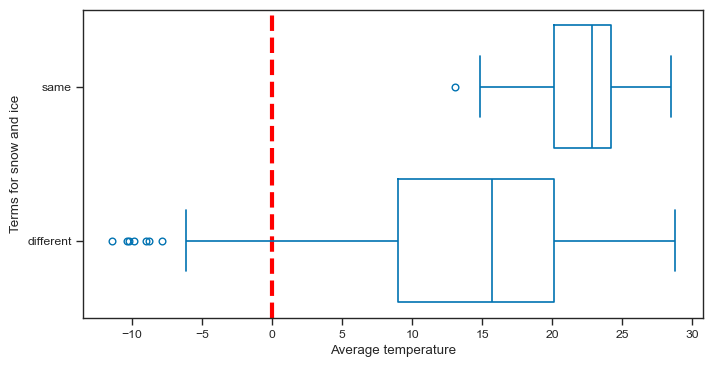

In [38]:
plt.figure(figsize=(8, 4))
plt.axvline(x=0, 
            color='red',
            linestyle='--',
            linewidth=3)
sns.boxplot(data=df_merged_f, x='Temperature', 
            y='Number_of_terms_bin', fill=False)
plt.xlabel('Average temperature')
plt.ylabel('Terms for snow and ice')
plt.show()

Perform the t-test using ``stats.ttest_ind``:

In [39]:
same_temp = df_merged_f.query('Number_of_terms_bin == "same"')['overall_avg_temp'].values
diff_temp = df_merged_f.query('Number_of_terms_bin == "different"')['overall_avg_temp'].values

stats.ttest_ind(same_temp, diff_temp, equal_var=False)

TtestResult(statistic=7.866057824961866, pvalue=2.6977910853495914e-08, df=25.60690803131017)

Languages where there is only one term for SNOW and ICE are spoken in the areas which are on average 7.5 degrees warmer! 

Finally, you need to recreate a map from the paper, showing the coordinates of languages with same or different terms for snow:

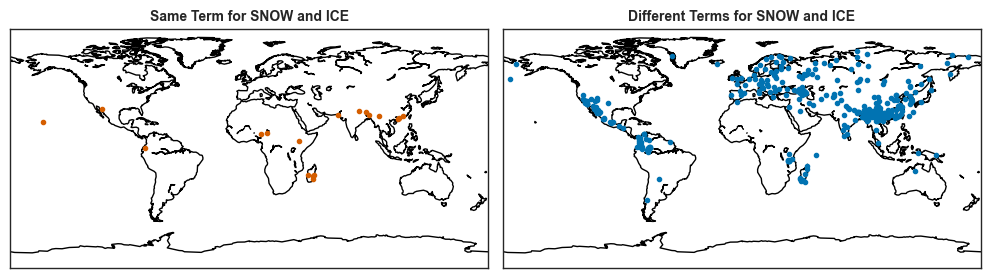

In [49]:

# Prepare data
x_same = df_merged_f.query('Number_of_terms_bin == "same"')['longitude']
y_same = df_merged_f.query('Number_of_terms_bin == "same"')['latitude']

x_different = df_merged_f.query('Number_of_terms_bin == "different"')['longitude']
y_different = df_merged_f.query('Number_of_terms_bin == "different"')['latitude']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First subplot for "same term"
ax = axes[0]
m1 = Basemap(projection='cyl', resolution='c', ax=ax)
m1.drawcoastlines(color='black')
m1.fillcontinents(color='white', lake_color='white')
m1.plot(x_same, y_same, 'ro', markersize=3, alpha=1)
ax.set_title('Same Term for SNOW and ICE', fontsize=10, weight='bold')

# Second subplot for "different terms"
ax = axes[1]
m2 = Basemap(projection='cyl', resolution='c', ax=ax)
m2.drawcoastlines(color='black')
m2.fillcontinents(color='white', lake_color='white')
m2.plot(x_different, y_different, 'bo', markersize=3, alpha=1)
ax.set_title('Different Terms for SNOW and ICE', fontsize=10, weight='bold')

# Adjust layout and display
plt.tight_layout()
plt.show()